In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras

In [14]:
PATH = "/content/drive/MyDrive/Projects/Yoga-82/A_Notebooks/"

NUM_CLASSES = 5

IMAGE_RESIZE = 224
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']



# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

class_name = sorted({'Bow_Pose_or_Dhanurasana_': 0,
 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_': 1,
 'Cobra_Pose_or_Bhujangasana_': 2,
 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_': 3,
 'Tree_Pose_or_Vrksasana_': 4}.keys())

def get_score_label(score):
    if score > 80:
        return "Pro"

    elif score > 65:
        return "Good"
    
    elif score > 50:
        return "Average"

    elif score > 30:
        return "Rookie"

    else:
        return "Try Again"

In [26]:
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator()

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

test_generator = data_generator.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 


Found 1523 images belonging to 5 classes.
Found 244 images belonging to 5 classes.
Found 244 images belonging to 5 classes.


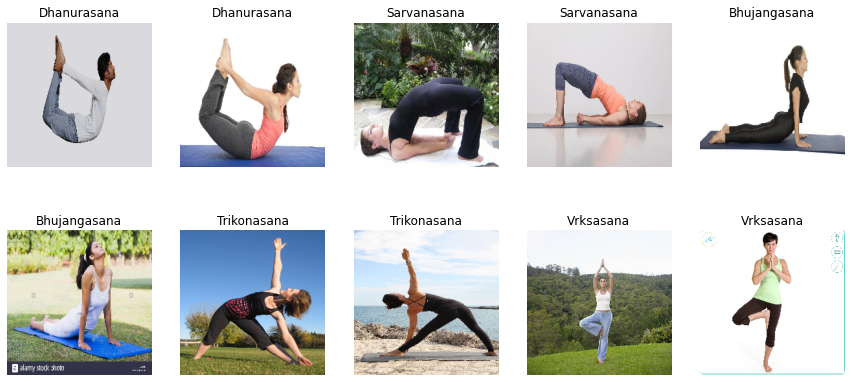

In [4]:
ds_dir_demo = "/content/drive/MyDrive/Projects/Yoga-82/demo/"

img_paths = os.listdir(ds_dir_demo)

f, ax = plt.subplots(2, 5, figsize = (15, 7))

for i, img_path in enumerate(img_paths):
    # image_path = "/content/drive/MyDrive/Projects/Yoga-82/demo/yoga_demo1.png"
    # image_path = "/content/drive/MyDrive/Projects/Yoga-82/demo/Capture4.JPG"
    image_path = ds_dir_demo+img_path

    image = tf.keras.preprocessing.image.load_img(image_path, target_size= IMG_SIZE)

    # input_arr = tf.keras.preprocessing.image.img_to_array(image)

    # input_arr = np.array([input_arr])  # Convert single image to a batch.

    # predictions = model.predict(input_arr)
    # idx = np.argmax(predictions)

    # # img=mpimg.imread(image_path)
    # # # plt.imshow(img)
    # i = i%10

    ax[i//5, i%5].imshow(image)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f"{img_path[:-5]}")    


In [55]:
def get_model(IMAGE_RESIZE=224):
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    # rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    # Create the base model from the pre-trained model inception v3
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense32 = tf.keras.layers.Dense(32, activation = 'relu')
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION)


    inputs = tf.keras.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3))
    # x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)

    
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)



    base_learning_rate = 0.005
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)

    # model.compile(optimizer=optimizer,
    #               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    #               metrics=['accuracy'])



    # optimizer = tf.keras.optimizers.SGD(lr = 0.005, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer = optimizer, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

    return model

In [56]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# # Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)



# base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)


# prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)


# inputs = tf.keras.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3))
# # x = data_augmentation(inputs)
# x = preprocess_input(inputs)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)


# # base_learning_rate = 0.0001
# # optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)

# # model.compile(optimizer=optimizer,
# #               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# #               metrics=['accuracy'])



# sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
# model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [63]:
model = get_model()

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 256

In [64]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/Projects/Models/vgg16_best.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 10,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 8.1480 - accuracy: 0.2860

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 4s 382ms/step - loss: 8.0201 - accuracy: 0.2882 - val_loss: 3.9599 - val_accuracy: 0.3900
Epoch 2/10
10/10 [==============================] - 3s 325ms/step - loss: 3.1430 - accuracy: 0.3986 - val_loss: 2.5710 - val_accuracy: 0.4700
Epoch 3/10
10/10 [==============================] - 3s 356ms/step - loss: 3.0790 - accuracy: 0.5013 - val_loss: 2.6322 - val_accuracy: 0.5300
Epoch 4/10
10/10 [==============================] - 3s 369ms/step - loss: 2.1525 - accuracy: 0.5324 - val_loss: 2.2690 - val_accuracy: 0.6000
Epoch 5/10
10/10 [==============================] - 3s 349ms/step - loss: 2.4234 - accuracy: 0.6294 - val_loss: 1.4636 - val_accuracy: 0.7000
Epoch 6/10
10/10 [==============================] - 4s 377ms/step - loss: 2.1046 - accuracy: 0.6088 - val_loss: 1.2506 - val_accuracy: 0.7200
Epoch 7/10
10/10 [==============================] - 3s 333ms/step - loss: 1.6952 - accuracy: 0.6748 - val_loss: 1.1095 - val_accuracy: 0.7600
Epoch 8/10
10/10 

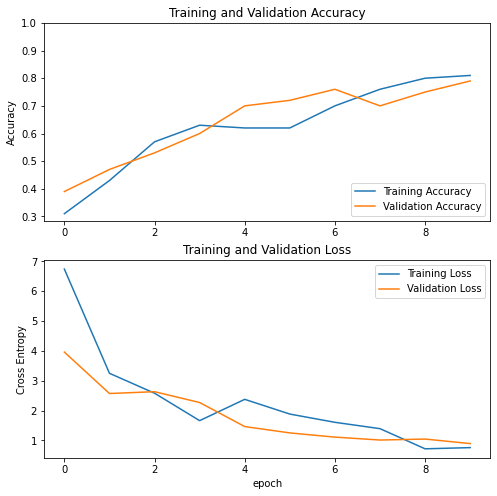

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
model_path = "/content/drive/MyDrive/Projects/Models/vgg16_best.h5"

model = keras.models.load_model(model_path)


In [71]:

def_img_list50 = []
def_img_list70 = []
def_img_list80 = []

for cls in test_generator.class_indices:
    temp_dir = "/content/drive/MyDrive/Projects/Yoga-82/A_Notebooks/test/"
    temp_dir = temp_dir + cls+'/'
    t_path = os.listdir(temp_dir)
    pred_list = []
    pred_array_2d = np.zeros((len(t_path), 5))

    curr_index = test_generator.class_indices[cls]

    for i, tt_path in enumerate(t_path):
        image_path = temp_dir + tt_path
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_size, image_size))
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        # input_arr = preprocess_input(input_arr)

        input_arr = np.array([input_arr])  # Convert single image to a batch.

        predictions = model.predict(input_arr)

        if predictions[0][np.argmax(predictions)] < 0.5:
            def_img_list50.append(image_path)

        elif predictions[0][np.argmax(predictions)] < 0.7:
            def_img_list70.append(image_path)

        elif predictions[0][np.argmax(predictions)] < 0.8:
            def_img_list80.append(image_path)


        pred_list.append(predictions)
        pred_array_2d[i] = np.squeeze(predictions)

    predicted_class_indices = []
    for pred in pred_list:
        predicted_class_indices.append( np.argmax(np.array(pred), axis = 1)[0])
        pred_array = np.array(predicted_class_indices)

    

    print(cls, np.sum(pred_array==curr_index)/len(predicted_class_indices))
    
    # flag = False
    # if curr_index == 0:
    tsum70 = 0
    tsum50 = 0
    tsum80 = 0
    for j in pred_array_2d:
        if j[curr_index]*100>80:
            tsum80 += 1
        if j[curr_index]*100>70:
            tsum70 += 1
        if j[curr_index]*100>50:
            tsum50 += 1

    flag = True
    print(len(pred_array))
    print(tsum50, tsum50/len(pred_array))
    print(tsum70, tsum70/len(pred_array))
    print(tsum80, tsum80/len(pred_array))
    # if flag:
    #     break

Bow_Pose_or_Dhanurasana_ 0.5925925925925926
27
16 0.5925925925925926
15 0.5555555555555556
15 0.5555555555555556
Bridge_Pose_or_Setu_Bandha_Sarvangasana_ 0.7894736842105263
38
28 0.7368421052631579
28 0.7368421052631579
28 0.7368421052631579


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Cobra_Pose_or_Bhujangasana_ 0.8133333333333334
75
60 0.8
58 0.7733333333333333
55 0.7333333333333333
Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_ 0.7464788732394366
71
53 0.7464788732394366
51 0.7183098591549296
49 0.6901408450704225
Tree_Pose_or_Vrksasana_ 0.8787878787878788
33
29 0.8787878787878788
27 0.8181818181818182
27 0.8181818181818182


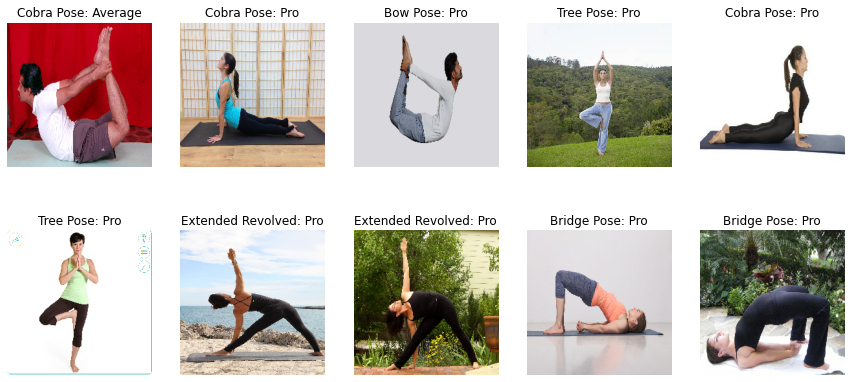

In [73]:
ds_dir_demo = "/content/drive/MyDrive/Projects/Yoga-82/A_Notebooks/demo_test_result/"

img_paths = os.listdir(ds_dir_demo)

f, ax = plt.subplots(2, 5, figsize = (15, 7))

for i, img_path in enumerate(img_paths):
    # image_path = "/content/drive/MyDrive/Projects/Yoga-82/demo/yoga_demo1.png"
    # image_path = "/content/drive/MyDrive/Projects/Yoga-82/demo/Capture4.JPG"
    image_path = ds_dir_demo+img_path

    image = tf.keras.preprocessing.image.load_img(image_path, target_size= IMG_SIZE)

    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    input_arr = np.array([input_arr])  # Convert single image to a batch.

    predictions = model.predict(input_arr)
    idx = np.argmax(predictions)

    # img=mpimg.imread(image_path)
    # # plt.imshow(img)
    i = i%10

    ax[i//5, i%5].imshow(image)
    ax[i//5, i%5].axis('off')
    cname = class_name[idx].split('_')

    scr_label = get_score_label(int(predictions[0][idx]*100))

    ax[i//5, i%5].set_title(f"{cname[0]} {cname[1]}: {scr_label}")    

